In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import shutil
from moviepy.editor import *
from tqdm import tqdm_notebook as tqdm
from datetime import datetime, time, timedelta
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import torch
import moviepy

In [2]:
from paddleocr import PaddleOCR, draw_ocr
ocr = PaddleOCR(lang="en", show_log=False) # need to run only once to download and load model into memory

In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32,32,kernel_size=3)
        self.conv3 = nn.Conv2d(32,64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.hidden= nn.Linear(64*18*14, 64)
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x) 
        
        x = self.relu(self.conv2(x)) 
        x = self.pool(x)
        
        x = self.relu(self.conv3(x)) 
        x = self.pool(x)
        x = x.view(x.size(0), -1) # [batch_size, 64*18*14=16128]
        
        
        x = self.relu(self.hidden(x))
        x = self.drop(x)
        
        x = self.sig(self.out(x))
        return x


model = NeuralNet()

In [4]:

def display_image(img_path, show=False):
    
    img = Image.open(img_path)
    img = img.resize((160, 128)).convert('RGB')
    
    plt.imshow(img)                           
    plt.axis('off')
    plt.show()


transform = transforms.Compose([
    transforms.ToTensor()
])
 
def load_prediction_image(img_path, show=False):
    
    img = Image.open(img_path)
    img = img.resize((160, 128)).convert('RGB')#224,224
       
    
    if show:
        plt.imshow(img)                           
        plt.axis('off')
        plt.show()
        
    return transform(img)


def show_image(img):
    plt.imshow(img)                           
    plt.axis('off')
    plt.show()

    
def get_time_tuple(t):
    return tuple(map(float, t.split(':')))


def get_next_frame_time(curr_time, skip=1):
    d = (datetime(year=2000, month=12, day=1, hour=int(curr_time[0]), 
                  minute=int(curr_time[1]), second=int(curr_time[2])) + timedelta(seconds=skip))
    return (d.hour, d.minute,d.second)  

# Filter ball start shots

In [5]:
shot_img_paths = sorted(glob.glob("./melVSsyd_frames/*.jpg"))

In [23]:
len(shot_img_paths)

10014

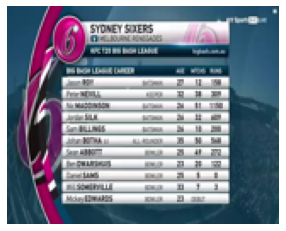

In [24]:
im = display_image(shot_img_paths[1], True)

In [6]:
model = NeuralNet()
model.load_state_dict(torch.load('resnet50_best.pth'))
model.eval()


NeuralNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden): Linear(in_features=16128, out_features=64, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sig): Sigmoid()
)

In [26]:
detected = []

for img_path in tqdm(shot_img_paths):
    
    img_tensor = load_prediction_image(img_path)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    score = model(torch.tensor(img_tensor)).detach().numpy()[0][0]

    if score > 0.9:
        #display_image(img_path)
        detected.append(img_path)
        # save filtered images separately.
        shutil.copy(img_path, './melVSsyd_filtered/{}'.format(img_path.split('/')[-1]))

  0%|          | 0/10014 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
detected = sorted(glob.glob("./melVSsyd_filtered/*.jpg"))

In [8]:
#unique scenes containing ball start frames
detected_idxs = sorted(list(set(map(lambda x:int(x.split('-')[2]), detected))))

In [9]:
len(detected_idxs)

152

In [10]:
df = pd.read_csv('./melVSsyd-Scenes.csv')
df.head(5)

,Timecode List:,00:00:18.100,00:00:18.700,00:00:26.667,00:00:32.000,00:00:37.333,00:00:37.933,00:00:38.533,00:00:39.133,00:00:39.733,...,01:43:47.500,01:43:48.100,01:43:48.700,01:43:49.333,01:43:52.633,01:43:53.233,01:43:53.833,01:43:56.200,01:43:57.300,01:43:58.533
0,Scene Number,Start Frame,Start Timecode,Start Time (seconds),End Frame,End Timecode,End Time (seconds),Length (frames),Length (timecode),Length (seconds),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:00:00.000,0.000,543,00:00:18.100,18.100,543,00:00:18.100,18.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,544,00:00:18.100,18.100,561,00:00:18.700,18.700,18,00:00:00.600,0.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,562,00:00:18.700,18.700,800,00:00:26.667,26.667,239,00:00:07.967,7.967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,801,00:00:26.667,26.667,960,00:00:32.000,32.000,160,00:00:05.333,5.333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
get_time_tuple(df.iloc[4][2])#first scene's start time

(0.0, 0.0, 26.667)

In [11]:
shot_start_times = []

#get start time codes of relevant scenes
for idx in detected_idxs:
    shot_start_times.append(get_time_tuple(df.iloc[idx][2]))

In [12]:

clip = moviepy.editor.VideoFileClip('videos/melVSsyd.mp4')

In [25]:
def get_overs(img_arr, display=False):
    img_arr = enlarge_image(img_arr[:20, 186:218])
    
    if display:
        show_image(img_arr)
    over_count = ocr.ocr(img_arr, cls=False)[0]
    
    
    if(len(over_count)) == 1:
        over_count = over_count[0][-1][0]
    else:
        return img_arr, None
    
    if False in [i in '0123456789.' for i in str(over_count)]:
        return img_arr, None
    else:
        return img_arr, over_count

def sharpen_image(img_arr, display=False, thresh=180):
    ret, mask = cv2.threshold(img_arr, thresh, 255, cv2.THRESH_BINARY)
    return mask


def enlarge_image(img_arr, basewidth=300):
    img = Image.fromarray(img_arr)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    return np.asarray(img)

def enlarge_image_cv2(img, basewidth=300):
    wpercent = (basewidth/float(img.shape[1]))
    hsize = int((float(img.shape[0])*float(wpercent)))
    
    img = cv2.resize(img, (basewidth, hsize), cv2.INTER_AREA)

    return img


def get_score(img_arr, display=False):
    img_arr = enlarge_image(img_arr[:20, 125:175])
    if display:
        show_image(img_arr)
    
    score = ocr.ocr(img_arr, cls=False)[0]
    
    if len(score) == 1:
        score = score[0][-1][0]
    else:
        return None
    
    if False in [i in '0123456789/' for i in str(score)]:
        return None
    else:
        return score
   

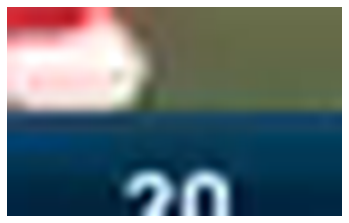

20


In [37]:
im0 = clip.get_frame(((1, 36,46)))
scorebox = im0[314:347,:]
show_image(scorebox)
_, result = get_overs(scorebox, display=True)
print(result)

In [38]:
shot_end_times = [(0,0,0)]
filtered_shot_start_times = []
shot_score_values = []
for start_time in tqdm(shot_start_times):

    # prevent processing of same ball
    if shot_end_times[-1] > start_time:
        continue
    
    curr_time = start_time
    
    # get the first frame when over is shown
    while 1:
        
        frame = clip.get_frame(curr_time)
        scorebox = cv2.cvtColor(frame[314:347,:], cv2.COLOR_RGB2GRAY)
        curr_over_img, curr_over_val = get_overs(scorebox)
        if curr_over_val != None:
            print('first frame', curr_over_val)
            print(curr_time)
            break
        curr_time = get_next_frame_time(curr_time)
    
    
    last_over_img = np.asarray(curr_over_img)
    last_over_val = curr_over_val
    ssv = []
    
    # process further frames until over count changes
    i = 0
    while 1:
       
        frame = clip.get_frame(curr_time)
        scorebox = cv2.cvtColor(frame[314:347,:], cv2.COLOR_RGB2GRAY)
        curr_over_img, curr_over_val = get_overs(scorebox)
        
        if (curr_over_val != None):
            ssv.append((get_score(scorebox), curr_over_val))
        
            # print('over: ' ,curr_over_val, " ", last_over_val)
            
            if (float(curr_over_val) > float(last_over_val)):
                print('over count changed')
                
                #show_image(curr_over_img)
                print(curr_over_val)
                print('current time ', curr_time)
                break
            
        curr_time = get_next_frame_time(curr_time)
        
        
    # save information
    shot_end_times.append(curr_time)
    filtered_shot_start_times.append(start_time)
    shot_score_values.append(ssv)

  0%|          | 0/152 [00:00<?, ?it/s]

first frame 0
(0, 9, 6)
over count changed
0.3
current time  (0, 9, 9)
first frame 0.3
(0, 9, 27)
over count changed
0.4
current time  (0, 9, 41)
first frame 0.4
(0.0, 11.0, 4.667)
over count changed
0.5
current time  (0, 11, 12)
first frame 0.5
(0.0, 11.0, 18.2)
over count changed
1.1
current time  (0, 12, 40)
first frame 1.1
(0, 13, 4)
over count changed
1.2
current time  (0, 13, 12)
first frame 1.3
(0.0, 14.0, 37.867)


KeyboardInterrupt: 

In [28]:
shot_end_times = shot_end_times[1:]

In [294]:
len(shot_end_times)

14

In [29]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [30]:
shots_info = [{'start': (0,0,0), 'end': (0,0,0), 'runs': 0, 'wickets': 0}]

for ball in range(len(filtered_shot_start_times)):
    # print(ball)
    shot_info = {
        'start': filtered_shot_start_times[ball],
        'end': shot_end_times[ball]
    }
    
    if ball != (len(filtered_shot_start_times) -1):
        score = most_common(shot_score_values[ball])[0]
    else: 
        score = '1000/1000' #random score for last ball

    if '/' in score:
    
        shot_info['wickets'], shot_info['runs'] = list(map(int, score.split('/')))
    
        shots_info.append(shot_info)

In [31]:
highlight_clips = []

for ball in range(1,len(shots_info[1:])):
    
   if((shots_info[ball+1]['runs'] - shots_info[ball]['runs'] >= 4) or
       (shots_info[ball+1]['wickets'] != shots_info[ball]['wickets'])):
       
        highlight_clips.append(clip.subclip(t_start=shots_info[ball]['start'],
                                          t_end=shots_info[ball]['end']))

In [32]:
highlight_clips.append(clip.subclip(t_start=shots_info[-1]['start'],
                                        t_end=shots_info[-1]['end']))#always include last ball of the innings


In [33]:


final_clip = concatenate_videoclips(highlight_clips)

In [34]:
final_clip.write_videofile('hl_melVSsyd_inn_1_pad.mp4')

Moviepy - Building video hl_melVSsyd_inn_1_pad.mp4.
MoviePy - Writing audio in hl_melVSsyd_inn_1_padTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video hl_melVSsyd_inn_1_pad.mp4



Moviepy - Done !
Moviepy - video ready hl_melVSsyd_inn_1_pad.mp4


In [125]:
!ffmpeg -i 'hl_melVSsyd_inn_1_pad.mp4' -c:v libx264 -profile:v baseline -level 5.0 -pix_fmt yuv420p -max_muxing_queue_size 1024 'hl_melVSsyd_inn_1_padd.mp4'

/bin/bash: ffmpeg: command not found


In [21]:
shots_info

[{'start': (0, 0, 0), 'end': (0, 0, 0), 'runs': 0, 'wickets': 0},
 {'start': (0.0, 8.0, 25.933), 'end': (0, 9, 41), 'wickets': 0, 'runs': 1},
 {'start': (0.0, 11.0, 4.667), 'end': (0, 11, 12), 'wickets': 1, 'runs': 1},
 {'start': (0.0, 11.0, 18.2), 'end': (0, 11, 29), 'wickets': 1, 'runs': 1},
 {'start': (0.0, 12.0, 30.9), 'end': (0, 12, 40), 'wickets': 1, 'runs': 1},
 {'start': (0.0, 13.0, 3.333), 'end': (0, 13, 12), 'wickets': 1, 'runs': 1},
 {'start': (0.0, 14.0, 37.867), 'end': (0, 14, 46), 'wickets': 1, 'runs': 1},
 {'start': (0.0, 15.0, 9.533), 'end': (0, 15, 20), 'wickets': 1, 'runs': 1},
 {'start': (0.0, 15.0, 36.667), 'end': (0, 15, 48), 'wickets': 1, 'runs': 1},
 {'start': (0.0, 16.0, 24.433), 'end': (0, 16, 34), 'wickets': 1, 'runs': 2},
 {'start': (0.0, 16.0, 54.233), 'end': (0, 17, 6), 'wickets': 1, 'runs': 2},
 {'start': (0.0, 17.0, 35.333), 'end': (0, 17, 45), 'wickets': 1, 'runs': 3},
 {'start': (0.0, 18.0, 0.533), 'end': (0, 18, 12), 'wickets': 1, 'runs': 4},
 {'start'